# CSI 4106 Introduction to Artificial Intelligence 
## Assignment 2: Machine Learning

## Report Title: Data Preparation, Model Development and Parameter Optimization for Machine Learning

### Identification

Name: Alex Govier <br/>
Student Number: 300174954

#### Import Necessary Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder

### Exploratory Analysis

#### 1. Loading Dataset and Summary

In [19]:
# Loading the diabetes dataset from my GitHub
diabetes_url = "https://github.com/alex-govier5/intro-to-ai/raw/master/A2/diabetes_prediction_dataset.csv"
dataset = pd.read_csv(diabetes_url)

This is a large dataset of around 100,000 rows containing patient's medical information. It has their gender which is categorical, it has their age which is numerical, it has hypertension which is categorical in binary indicating whether the patient has hypertension or not, it has heart_disease which is also categorical and binary indicating if the patient has heart disease or not, it has smoking_history which is categorical indicating if they've never smoked currently smoke, not currently smoke, or no info, it has bmi which is numerical indicating the patient's body mass index, it has the HbA1c_level, indicating the patient's Hemoglobin A1c level, it has the bloode_glucose_level which is numerical, indicating the patient's blood sugar level, and then finally it has diabetes which is the target variable which is categorical and binary, indicating whether the patient has diabetes or not (0 = No, 1 = Yes).

#### 2. Feature Distribution Analysis
Here I will visualize all of my attributes and then provide an analysis.

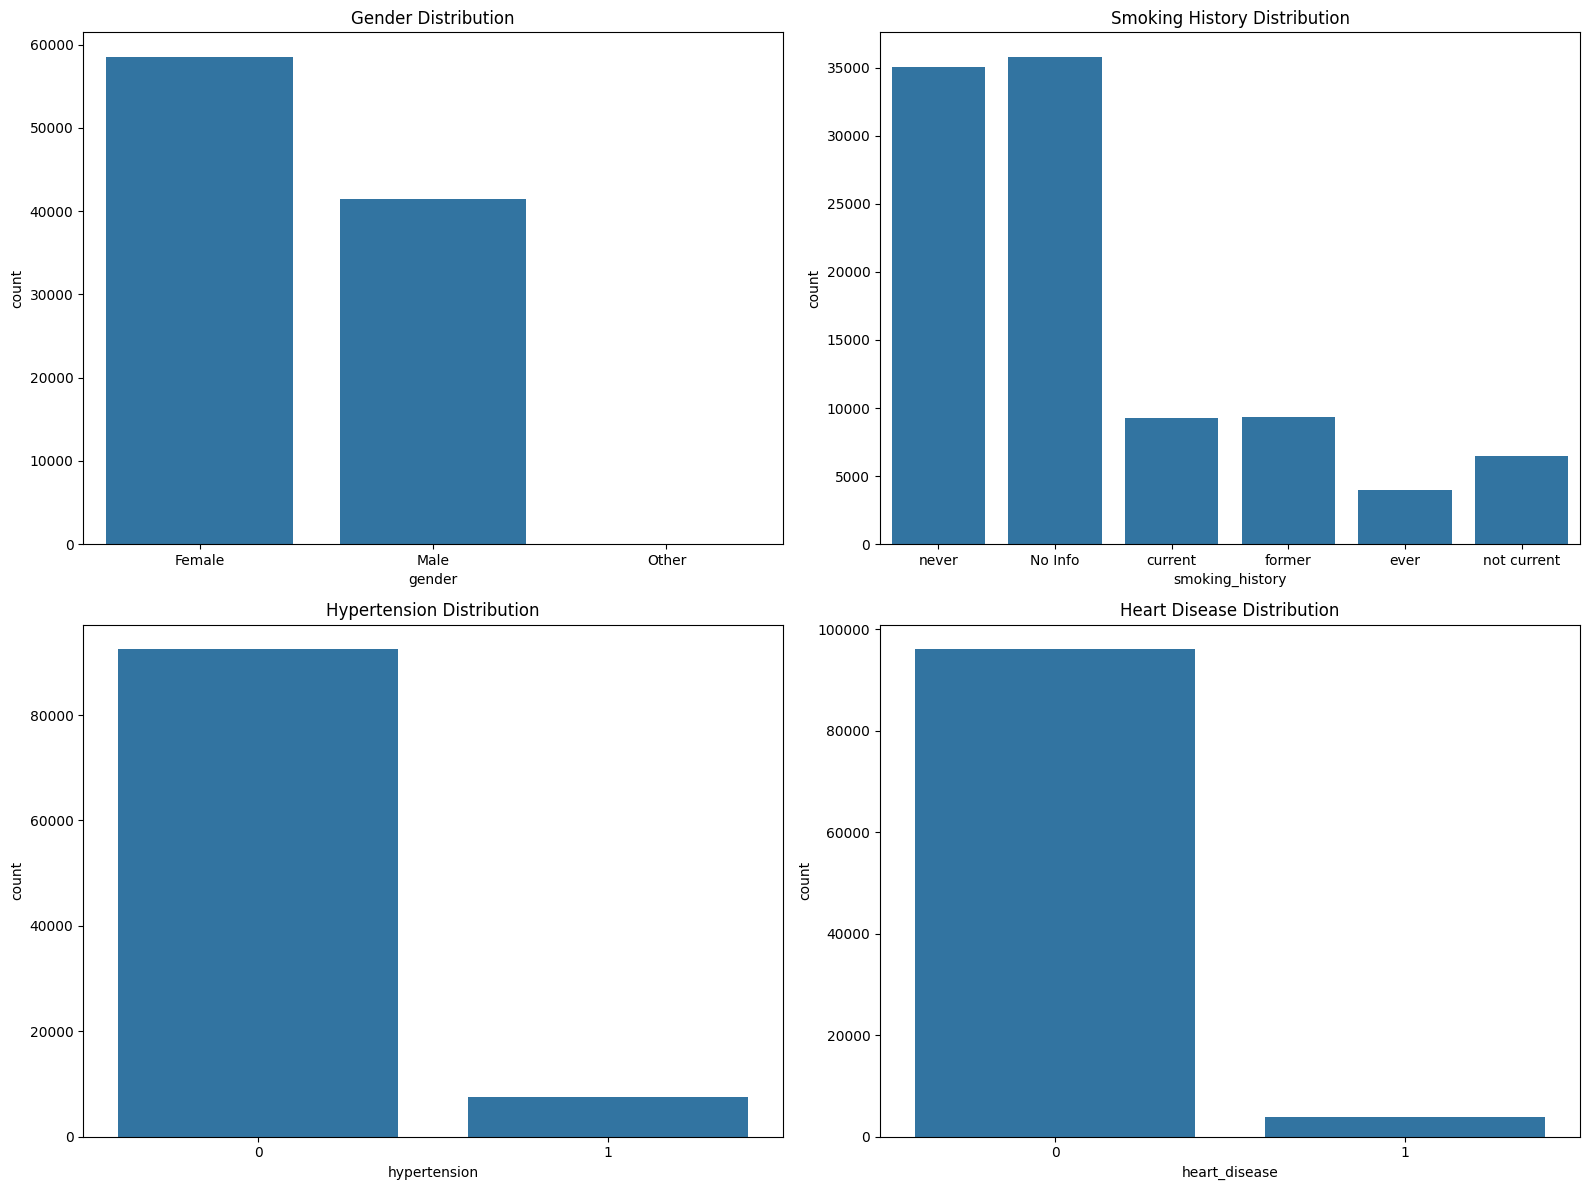

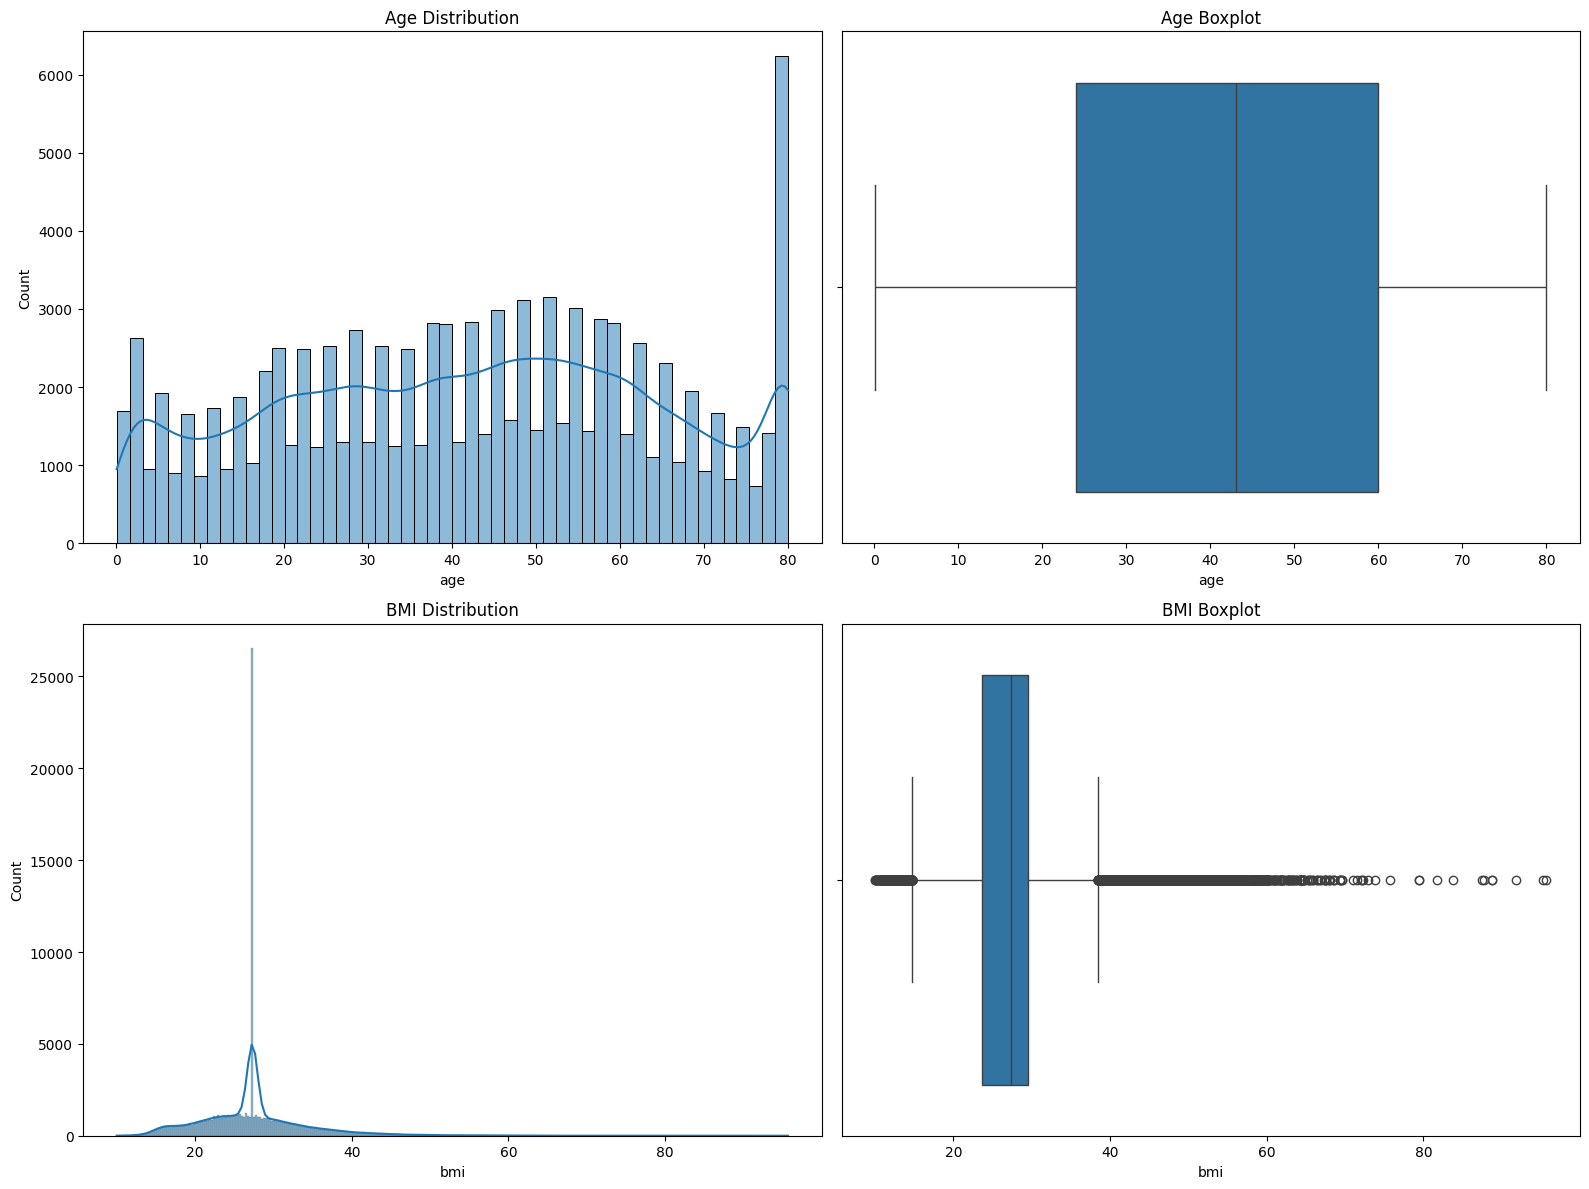

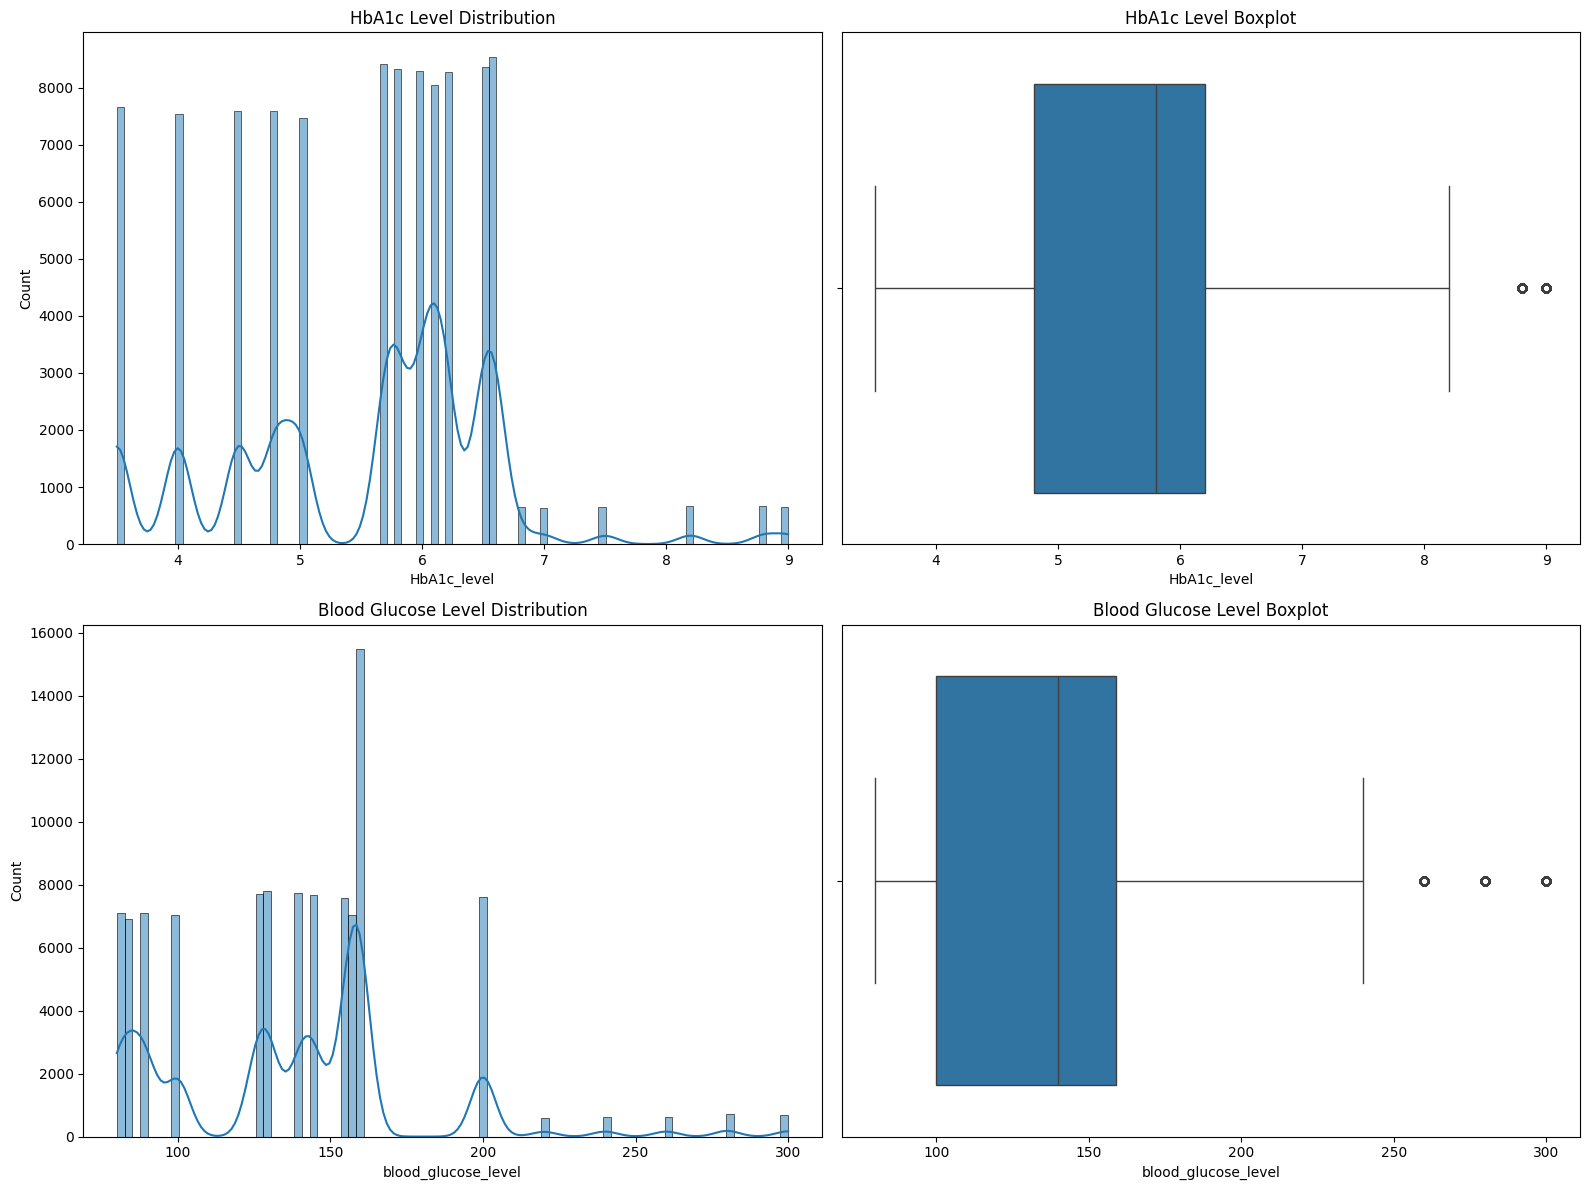

In [20]:
# Convert the dataset to a dataframe
df = pd.DataFrame(dataset)

# Will separate visualizations by type, so countplots for categorical attributes
plt.figure(figsize=(16, 12))

# Gender
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')

# Smoking history
plt.subplot(2, 2, 2)
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')

# Hypertension
plt.subplot(2, 2, 3)
sns.countplot(x='hypertension', data=df)
plt.title('Hypertension Distribution')

# Heart disease
plt.subplot(2, 2, 4)
sns.countplot(x='heart_disease', data=df)
plt.title('Heart Disease Distribution')

plt.tight_layout()
plt.show()

# Histograms and boxplots for numerical attributes

plt.figure(figsize=(16, 12))

# Age
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['age'])
plt.title('Age Boxplot')

# BMI 
plt.subplot(2, 2, 3)
sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['bmi'])
plt.title('BMI Boxplot')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))

# HbA1c
plt.subplot(2, 2, 1)
sns.histplot(df['HbA1c_level'], kde=True)
plt.title('HbA1c Level Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['HbA1c_level'])
plt.title('HbA1c Level Boxplot')

# Bloog glucose
plt.subplot(2, 2, 3)
sns.histplot(df['blood_glucose_level'], kde=True)
plt.title('Blood Glucose Level Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['blood_glucose_level'])
plt.title('Blood Glucose Level Boxplot')

plt.tight_layout()
plt.show()
